In [1]:
import os
import random
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

## 1. Description
The goal of this project is to use Generative Adversarial Networks (GANs), specifically a CycleGAN, to transform ordinary photos into images that mimic the style of Claude Monet's paintings. The CycleGAN will learn to translate images from the domain of photographs to the domain of Monet paintings without needing paired examples of photos and paintings.

Monet Paintings Dataset:
- Number of images: 300
- Unique dimensions: [[256 256]]
- Color modes: {'RGB'}

Photos Dataset:
- Number of images: 7038
- Unique dimensions: [[256 256]]
- Color modes: {'RGB'}

In [2]:
# Load a few Monet paintings
monet_images_dir = './data/monet_jpg'
monet_images = [Image.open(os.path.join(monet_images_dir, img)) for img in os.listdir(monet_images_dir)[:5]]

# Load a few photos
photo_images_dir = './data/photo_jpg'
photo_images = [Image.open(os.path.join(photo_images_dir, img)) for img in os.listdir(photo_images_dir)[:5]]

In [3]:
# Function to get dataset statistics
def get_dataset_stats(image_dir):
    image_count = 0
    dimensions = []
    color_modes = set()

    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        with Image.open(img_path) as img:
            image_count += 1
            dimensions.append(img.size)  # (width, height)
            color_modes.add(img.mode)

    dimensions = np.array(dimensions)
    unique_dimensions = np.unique(dimensions, axis=0)

    print(f"Number of images: {image_count}")
    print(f"Unique dimensions: {unique_dimensions}")
    print(f"Color modes: {color_modes}")

# Describing Monet paintings dataset
print("Monet Paintings Dataset:")
monet_images_dir = './data/monet_jpg'
get_dataset_stats(monet_images_dir)

# Describing Photos dataset
print("\nPhotos Dataset:")
photo_images_dir = './data/photo_jpg'
get_dataset_stats(photo_images_dir)

Monet Paintings Dataset:
Number of images: 300
Unique dimensions: [[256 256]]
Color modes: {'RGB'}

Photos Dataset:
Number of images: 7038
Unique dimensions: [[256 256]]
Color modes: {'RGB'}


## 2. EDA

Monet Paintings:


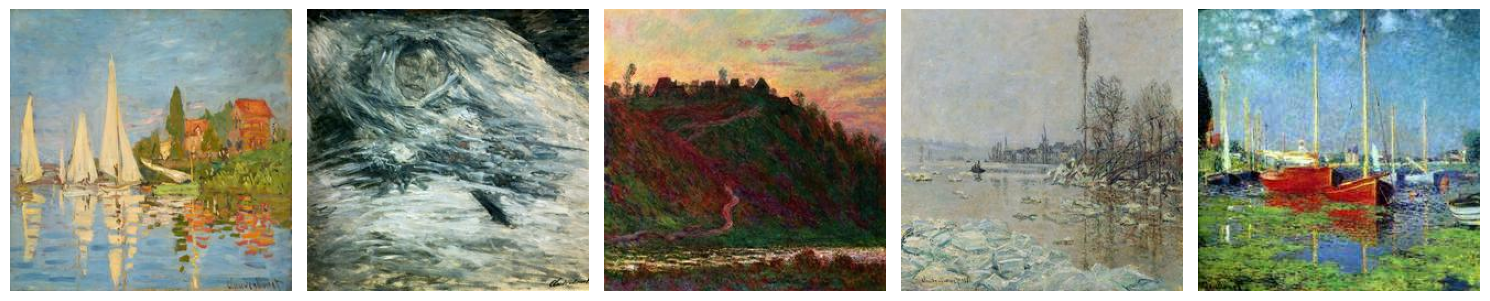

Photos:


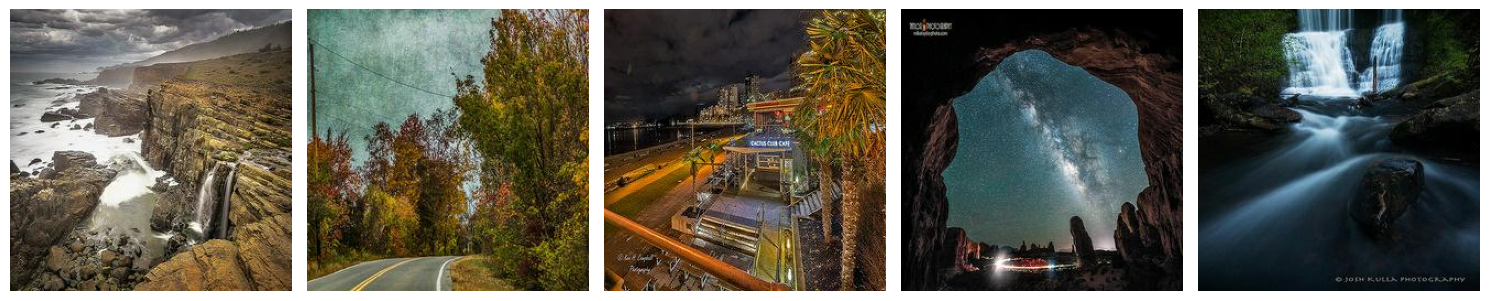

In [4]:
# Function to display a grid of images
def show_images(images, titles=None, cols=5, figsize=(15, 10)):
    assert (titles is None or len(images) == len(titles))
    n_images = len(images)
    cols = int(cols)  # Ensure that cols is an integer
    rows = np.ceil(n_images / float(cols)).astype(int)  # Calculate the number of rows as an integer
    fig = plt.figure(figsize=figsize)
    for n in range(n_images):
        ax = fig.add_subplot(rows, cols, n + 1)
        ax.imshow(images[n])
        if titles is not None:
            ax.set_title(titles[n])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Load a few Monet paintings
monet_images_dir = './data/monet_jpg'
monet_images = [Image.open(os.path.join(monet_images_dir, img)) for img in os.listdir(monet_images_dir)[:5]]

# Load a few photos
photo_images_dir = './data/photo_jpg'
photo_images = [Image.open(os.path.join(photo_images_dir, img)) for img in os.listdir(photo_images_dir)[:5]]

# Display Monet paintings
print("Monet Paintings:")
show_images(monet_images)

# Display Photos
print("Photos:")
show_images(photo_images)

### CustomTransform for Image Augmentation

In [5]:
class CustomTransform:
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(0.5),            # Randomly flip the image horizontally
            transforms.RandomRotation(10),               # Randomly rotate the image by +/- 10 degrees
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation, and hue
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate the image by up to 10%
            transforms.ToTensor(),                       # Convert the image to a tensor
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    # Normalize the image
        ])

    def __call__(self, img):
        img = self.transforms(img)
        return img

class MonetPhotoDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, transform=None):
        self.monet_images = [os.path.join(monet_dir, img) for img in os.listdir(monet_dir) if img.endswith('.jpg')]
        self.photo_images = [os.path.join(photo_dir, img) for img in os.listdir(photo_dir) if img.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return min(len(self.monet_images), len(self.photo_images))

    def __getitem__(self, idx):
        monet_img = Image.open(self.monet_images[idx]).convert("RGB")
        photo_img = Image.open(self.photo_images[idx]).convert("RGB")

        if self.transform:
            monet_img = self.transform(monet_img)
            photo_img = self.transform(photo_img)

        return monet_img, photo_img

In [6]:
# Create an instance of the custom transform
custom_transform = CustomTransform()

# Apply the custom transform to the Monet paintings dataset
monet_dataset = MonetPhotoDataset(monet_images_dir, photo_images_dir, transform=custom_transform)
photo_dataset = MonetPhotoDataset(photo_images_dir, photo_images_dir, transform=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

# DataLoader for batching and shuffling
monet_dataloader = DataLoader(monet_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
photo_dataloader = DataLoader(photo_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)

In [7]:
from itertools import zip_longest

class CombinedDataLoader:
    def __init__(self, monet_dataloader, photo_dataloader):
        self.monet_dataloader = monet_dataloader
        self.photo_dataloader = photo_dataloader

    def __iter__(self):
        return zip_longest(iter(self.monet_dataloader), iter(self.photo_dataloader), fillvalue=None)

    def __len__(self):
        return min(len(self.monet_dataloader), len(self.photo_dataloader))

combined_loader = CombinedDataLoader(monet_dataloader, photo_dataloader)

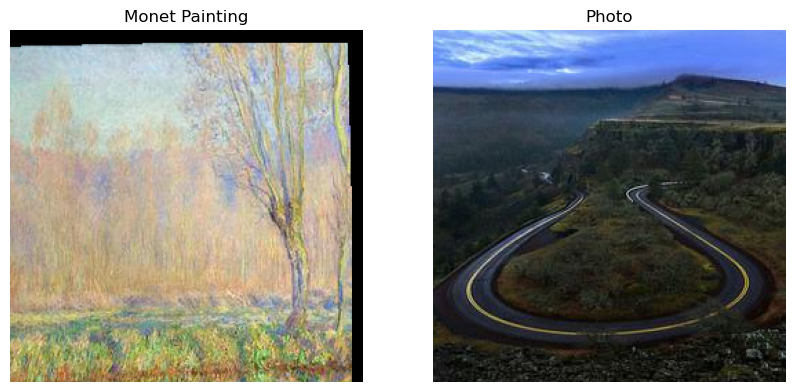

In [9]:
def show_images(monet_image, photo_image):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(monet_image.permute(1, 2, 0) * 0.5 + 0.5)
    axs[0].set_title("Monet Painting")
    axs[0].axis("off")

    axs[1].imshow(photo_image.permute(1, 2, 0) * 0.5 + 0.5)
    axs[1].set_title("Photo")
    axs[1].axis("off")
    plt.show()

# Get a batch of data
for monet_batch, photo_batch in combined_loader:
    if monet_batch is None or photo_batch is None:
        continue
    monet_images, _ = monet_batch
    photo_images, _ = photo_batch

    # Visualize
    for monet_image, photo_image in zip(monet_images, photo_images):
        show_images(monet_image, photo_image)
        break  # Display only the first batch
    break  # Display only the first batch

## 3. Model Architecture

#### Comparison
##### 1. standard GAN
In a standard GAN, there are two main components:
- Generator (G): This model generates new data instances (e.g., images) that resemble the training data. Its goal is to create data that the discriminator cannot distinguish from real data.
- Discriminator (D): This model evaluates the data produced by the generator against real data. Its goal is to correctly classify data as either "real" (from the training set) or "fake" (generated by G).

##### 2. CycleGAN
- Two Generators:
  - Generator G: Transforms images from domain X (e.g., photos) to domain Y (e.g., Monet-style paintings).
  - Generator F: Transforms images from domain Y (Monet-style paintings) back to domain X (photos).
- Two Discriminators:
  - Discriminator D_X: Tries to distinguish between real images from domain X and fake images generated by F.
  - Discriminator D_Y: Tries to distinguish between real images from domain Y and fake images generated by G.
- Cycle Consistency Loss:
  - To ensure that the transformation is meaningful, CycleGAN introduces the concept of cycle consistency. This means if you transform an image to the other domain and back again, you should get the original image. 
- Identity Loss (Optional but often used):This loss ensures that if you input an image from one domain into the generator corresponding to that domain, it should produce the same image. 


#### Summary
The code I've been working on implements a CycleGAN, which is a specific type of GAN designed for unpaired image-to-image translation. Unlike a standard GAN, which might generate new images from random noise, a CycleGAN is focused on transforming images from one domain to another (e.g., turning photos into Monet-style paintings).

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=1),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=1),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

# Example: Simplify the generator architecture by reducing the number of residual blocks
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Initial convolution block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # Downsampling
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )
        # Fewer Residual blocks
        self.res_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(3)])
        # Upsampling
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # Output layer
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 3, 7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res_blocks(x)
        x = self.deconv1(x)
        x = self.conv3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def discriminator_block(in_filters, out_filters, stride=2, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=stride, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(3, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)

In [11]:
from torch.amp import GradScaler

scaler = GradScaler()


/Users/bosstation/anaconda3/envs/dl/lib/python3.9/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [11]:
from tqdm import tqdm

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
generator_g = Generator().to(device)
generator_f = Generator().to(device)
discriminator_x = Discriminator().to(device)
discriminator_y = Discriminator().to(device)

# Optimizers
g_optimizer = torch.optim.Adam(generator_g.parameters(), lr=2e-4, betas=(0.5, 0.999))
f_optimizer = torch.optim.Adam(generator_f.parameters(), lr=2e-4, betas=(0.5, 0.999))
dx_optimizer = torch.optim.Adam(discriminator_x.parameters(), lr=2e-4, betas=(0.5, 0.999))
dy_optimizer = torch.optim.Adam(discriminator_y.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Loss functions
criterion_gan = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Training
epochs = 100
lambda_cycle = 10.0
lambda_identity = 5.0

for epoch in range(epochs):
    for monet_batch, photo_batch in tqdm(combined_loader):
        if monet_batch is None or photo_batch is None:
            continue

        monet, _ = monet_batch
        photo, _ = photo_batch
        monet, photo = monet.to(device), photo.to(device)

        # Reset gradients
        g_optimizer.zero_grad()
        f_optimizer.zero_grad()
        dx_optimizer.zero_grad()
        dy_optimizer.zero_grad()

        # Generate images
        fake_monet = generator_g(photo)
        cycled_photo = generator_f(fake_monet)
        fake_photo = generator_f(monet)
        cycled_monet = generator_g(fake_photo)

        # Identity loss
        same_monet = generator_g(monet)
        same_photo = generator_f(photo)
        identity_loss = criterion_identity(same_monet, monet) * lambda_identity + criterion_identity(same_photo, photo) * lambda_identity

        # GAN loss
        pred_fake_monet = discriminator_y(fake_monet)
        gan_loss_g = criterion_gan(pred_fake_monet, torch.ones_like(pred_fake_monet, device=device))

        pred_fake_photo = discriminator_x(fake_photo)
        gan_loss_f = criterion_gan(pred_fake_photo, torch.ones_like(pred_fake_photo, device=device))

        # Cycle loss
        cycle_loss = criterion_cycle(cycled_monet, monet) * lambda_cycle + criterion_cycle(cycled_photo, photo) * lambda_cycle

        # Total generator loss
        total_g_loss = gan_loss_g + cycle_loss + identity_loss
        total_f_loss = gan_loss_f + cycle_loss + identity_loss

        # Discriminator x
        pred_real_monet = discriminator_x(monet)
        loss_real_monet = criterion_gan(pred_real_monet, torch.ones_like(pred_real_monet, device=device))
        loss_fake_monet = criterion_gan(discriminator_x(fake_photo.detach()), torch.zeros_like(pred_fake_photo, device=device))
        dx_loss = (loss_real_monet + loss_fake_monet) * 0.5

        # Discriminator y
        pred_real_photo = discriminator_y(photo)
        loss_real_photo = criterion_gan(pred_real_photo, torch.ones_like(pred_real_photo, device=device))
        loss_fake_photo = criterion_gan(discriminator_y(fake_monet.detach()), torch.zeros_like(pred_fake_monet, device=device))
        dy_loss = (loss_real_photo + loss_fake_photo) * 0.5

        # Backpropagation
        total_g_loss.backward(retain_graph=True)
        total_f_loss.backward()
        dx_loss.backward()
        dy_loss.backward()
        
        g_optimizer.step()
        f_optimizer.step()
        dx_optimizer.step()
        dy_optimizer.step()

    print(f'Epoch [{epoch}/{epochs}] completed.')

880it [05:56,  2.47it/s]                       


Epoch [0/100] completed.


880it [12:12,  1.20it/s]                       


Epoch [1/100] completed.


880it [07:36,  1.93it/s]                       


Epoch [2/100] completed.


880it [03:22,  4.36it/s]                       


Epoch [3/100] completed.


880it [03:20,  4.40it/s]                       


Epoch [4/100] completed.


880it [03:18,  4.43it/s]                       


Epoch [5/100] completed.


880it [03:18,  4.43it/s]                       


Epoch [6/100] completed.


880it [03:17,  4.46it/s]                       


Epoch [7/100] completed.


880it [03:20,  4.38it/s]                       


Epoch [8/100] completed.


880it [03:18,  4.44it/s]                       


Epoch [9/100] completed.


880it [03:16,  4.49it/s]                       


Epoch [10/100] completed.


880it [03:16,  4.47it/s]                       


Epoch [11/100] completed.


880it [03:16,  4.49it/s]                       


Epoch [12/100] completed.


880it [03:18,  4.44it/s]                       


Epoch [13/100] completed.


880it [03:17,  4.45it/s]                       


Epoch [14/100] completed.


880it [03:16,  4.47it/s]                       


Epoch [15/100] completed.


880it [03:17,  4.46it/s]                       


Epoch [16/100] completed.


880it [03:16,  4.47it/s]                       


Epoch [17/100] completed.


880it [03:15,  4.50it/s]                       


Epoch [18/100] completed.


880it [03:16,  4.47it/s]                       


Epoch [19/100] completed.


880it [03:15,  4.49it/s]                       


Epoch [20/100] completed.


880it [03:16,  4.49it/s]                       


Epoch [21/100] completed.


880it [03:16,  4.48it/s]                       


Epoch [22/100] completed.


880it [03:15,  4.49it/s]                       


Epoch [23/100] completed.


880it [03:17,  4.46it/s]                       


Epoch [24/100] completed.


880it [03:16,  4.49it/s]                       


Epoch [25/100] completed.


880it [03:17,  4.46it/s]                       


Epoch [26/100] completed.


880it [03:17,  4.45it/s]                       


Epoch [27/100] completed.


880it [03:16,  4.47it/s]                       


Epoch [28/100] completed.


880it [03:15,  4.50it/s]                       


Epoch [29/100] completed.


880it [03:16,  4.48it/s]                       


Epoch [30/100] completed.


880it [03:16,  4.49it/s]                       


Epoch [31/100] completed.


880it [03:17,  4.45it/s]                       


Epoch [32/100] completed.


880it [03:15,  4.49it/s]                       


Epoch [33/100] completed.


880it [03:18,  4.43it/s]                       


Epoch [34/100] completed.


880it [03:16,  4.48it/s]                       


Epoch [35/100] completed.


880it [03:16,  4.47it/s]                       


Epoch [36/100] completed.


880it [03:15,  4.50it/s]                       


Epoch [37/100] completed.


880it [03:19,  4.40it/s]                       


Epoch [38/100] completed.


880it [03:17,  4.46it/s]                       


Epoch [39/100] completed.


880it [03:16,  4.48it/s]                       


Epoch [40/100] completed.


880it [03:17,  4.46it/s]                       


Epoch [41/100] completed.


880it [03:17,  4.45it/s]                       


Epoch [42/100] completed.


880it [03:16,  4.49it/s]                       


Epoch [43/100] completed.


880it [03:17,  4.46it/s]                       


Epoch [44/100] completed.


880it [03:17,  4.46it/s]                       


Epoch [45/100] completed.


880it [03:17,  4.46it/s]                       


Epoch [46/100] completed.


880it [03:17,  4.45it/s]                       


Epoch [47/100] completed.


880it [03:16,  4.48it/s]                       


Epoch [48/100] completed.


880it [03:18,  4.42it/s]                       


Epoch [49/100] completed.


880it [03:16,  4.48it/s]                       


Epoch [50/100] completed.


880it [03:17,  4.47it/s]                       


Epoch [51/100] completed.


880it [03:16,  4.47it/s]                       


Epoch [52/100] completed.


880it [03:16,  4.48it/s]                       


Epoch [53/100] completed.


880it [03:17,  4.46it/s]                       


Epoch [54/100] completed.


880it [03:17,  4.46it/s]                       


Epoch [55/100] completed.


880it [03:16,  4.48it/s]                       


Epoch [56/100] completed.


880it [03:17,  4.46it/s]                       


Epoch [57/100] completed.


880it [03:18,  4.43it/s]                       


Epoch [58/100] completed.


880it [03:16,  4.47it/s]                       


Epoch [59/100] completed.


880it [03:17,  4.46it/s]                       


Epoch [60/100] completed.


880it [03:18,  4.43it/s]                       


Epoch [61/100] completed.


880it [03:16,  4.48it/s]                       


Epoch [62/100] completed.


880it [03:16,  4.47it/s]                       


Epoch [63/100] completed.


880it [03:16,  4.47it/s]                       


Epoch [64/100] completed.


880it [03:17,  4.45it/s]                       


Epoch [65/100] completed.


880it [03:15,  4.50it/s]                       


Epoch [66/100] completed.


880it [03:19,  4.40it/s]                       


Epoch [67/100] completed.


880it [03:17,  4.46it/s]                       


Epoch [68/100] completed.


880it [03:16,  4.47it/s]                       


Epoch [69/100] completed.


880it [03:15,  4.50it/s]                       


Epoch [70/100] completed.


880it [03:17,  4.47it/s]                       


Epoch [71/100] completed.


880it [03:19,  4.42it/s]                       


Epoch [72/100] completed.


880it [03:16,  4.47it/s]                       


Epoch [73/100] completed.


880it [03:19,  4.41it/s]                       


Epoch [74/100] completed.


880it [03:16,  4.47it/s]                       


Epoch [75/100] completed.


880it [03:18,  4.43it/s]                       


Epoch [76/100] completed.


880it [03:17,  4.45it/s]                       


Epoch [77/100] completed.


880it [03:16,  4.48it/s]                       


Epoch [78/100] completed.


880it [03:16,  4.48it/s]                       


Epoch [79/100] completed.


880it [03:15,  4.49it/s]                       


Epoch [80/100] completed.


880it [03:15,  4.51it/s]                       


Epoch [81/100] completed.


880it [03:16,  4.49it/s]                       


Epoch [82/100] completed.


880it [03:17,  4.45it/s]                       


Epoch [83/100] completed.


880it [03:17,  4.46it/s]                       


Epoch [84/100] completed.


880it [03:18,  4.44it/s]                       


Epoch [85/100] completed.


880it [03:16,  4.47it/s]                       


Epoch [86/100] completed.


880it [03:15,  4.50it/s]                       


Epoch [87/100] completed.


880it [03:16,  4.48it/s]                       


Epoch [88/100] completed.


880it [03:15,  4.50it/s]                       


Epoch [89/100] completed.


880it [03:17,  4.46it/s]                       


Epoch [90/100] completed.


880it [03:18,  4.44it/s]                       


Epoch [91/100] completed.


880it [03:16,  4.49it/s]                       


Epoch [92/100] completed.


880it [03:17,  4.46it/s]                       


Epoch [93/100] completed.


880it [03:18,  4.44it/s]                       


Epoch [94/100] completed.


880it [03:18,  4.44it/s]                       


Epoch [95/100] completed.


880it [03:14,  4.53it/s]                       


Epoch [96/100] completed.


880it [03:17,  4.46it/s]                       


Epoch [97/100] completed.


880it [03:15,  4.50it/s]                       


Epoch [98/100] completed.


880it [03:17,  4.46it/s]                       

Epoch [99/100] completed.


In [12]:
from pytorch_fid import fid_score

# Paths to real images and generated images
real_images_path = './real_images'
generated_images_path = './generated_images'

# Calculate FID score
fid_value = fid_score.calculate_fid_given_paths([real_images_path, generated_images_path], batch_size, device, dims=2048)
print(f'FID Score: {fid_value}')

NameError: name 'batch_size' is not defined

Saving and Loading the Best Model4

In [ ]:
torch.save(generator_g.state_dict(), 'best_generator_g.pth')
torch.save(generator_f.state_dict(), 'best_generator_f.pth')
torch.save(discriminator_x.state_dict(), 'best_discriminator_x.pth')
torch.save(discriminator_y.state_dict(), 'best_discriminator_y.pth')